In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, plot_loss_and_r, CustomScaler


torch.manual_seed(42) # 42 for reproducibility
num=100 # Use this for testing and debugging
#num=None set to this when you want it to load
cwd = os.getcwd()
data_train = pd.read_csv(cwd+'/data/train_data_10k_conjugated_cores.csv')[:num]
data_test = pd.read_csv(cwd+'/data/test_data_500_analogues.csv') 

print("Formatting data - this may take a moment")
# Training data
train_Etddft = data_train['S1_TDDFT'].values 
train_Ezindo = data_train['S1_ZINDO'].values
train_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_train['fingerprint'].values])
net_input= np.concatenate((train_Ezindo.reshape(-1,1), train_fp),axis=1)

# Testing data (NOT VALIDATION DATA, use this once you model has been fully trained)
test_Etddft = data_test['E(S1_TDDFT)_analogue'].values 
test_Ezindo = data_test['E(S1_ZINDO)_analogue'].values
test_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_test['fingerprint'].values])


# Initialise model
criterion = nn.MSELoss()  

Formatting data - this may take a moment


Epoch 001/50 | Train Loss: 0.4451 | Val Loss: 0.2110 | Val Rho: 0.8834
Epoch 002/50 | Train Loss: 0.1562 | Val Loss: 0.1675 | Val Rho: 0.9070
Epoch 003/50 | Train Loss: 0.0957 | Val Loss: 0.1544 | Val Rho: 0.9169
Epoch 004/50 | Train Loss: 0.0548 | Val Loss: 0.1401 | Val Rho: 0.9255
Epoch 005/50 | Train Loss: 0.0294 | Val Loss: 0.1358 | Val Rho: 0.9268
Epoch 006/50 | Train Loss: 0.0173 | Val Loss: 0.1379 | Val Rho: 0.9231
Epoch 007/50 | Train Loss: 0.0124 | Val Loss: 0.1350 | Val Rho: 0.9272
Epoch 008/50 | Train Loss: 0.0097 | Val Loss: 0.1336 | Val Rho: 0.9284
Epoch 009/50 | Train Loss: 0.0081 | Val Loss: 0.1336 | Val Rho: 0.9263
Epoch 010/50 | Train Loss: 0.0068 | Val Loss: 0.1321 | Val Rho: 0.9295
Epoch 011/50 | Train Loss: 0.0055 | Val Loss: 0.1340 | Val Rho: 0.9267
Epoch 012/50 | Train Loss: 0.0051 | Val Loss: 0.1321 | Val Rho: 0.9283
Epoch 013/50 | Train Loss: 0.0042 | Val Loss: 0.1313 | Val Rho: 0.9287
Epoch 014/50 | Train Loss: 0.0035 | Val Loss: 0.1307 | Val Rho: 0.9298
Epoch 

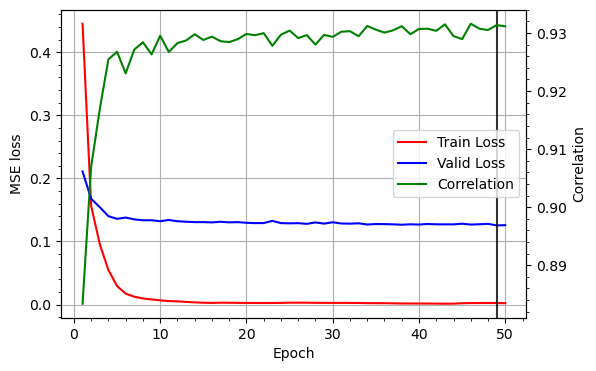

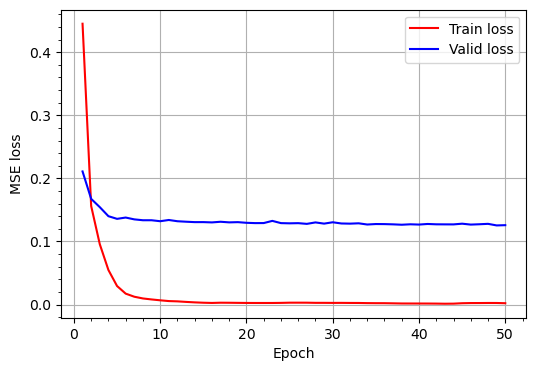


Final Results:
Test MSE: 0.04121
Test Correlation: 0.94144


In [ ]:
# -*- coding: utf-8 -*-
"""
Modified: Complete training pipeline with MLP class compatibility
"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, CustomScaler

# 固定随机种子保证可复现性
torch.manual_seed(42)
np.random.seed(42)

# 超参数配置
HIDDEN_LAYERS = [
    (512, nn.ReLU()),  # 增加神经元数量
    (256, nn.ReLU()),
    (128, nn.ReLU())    # 增加隐藏层数
]
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 50
VALID_RATIO = 0.2

# 加载数据
cwd = os.getcwd()
data_train = pd.read_csv(cwd+'/data/train_data_10k_conjugated_cores.csv')
data_test = pd.read_csv(cwd+'/data/test_data_500_analogues.csv') 

# 数据预处理函数（修改：分离输入和目标值的标准化）
def prepare_data(input_data, target_data, input_scaler=None, target_scaler=None, fit=False):
    """数据标准化处理"""
    if fit:
        input_scaler = CustomScaler()  # 仅标准化输入特征（ZINDO能量 + 指纹）
        target_scaler = StandardScaler()  # 单独标准化目标值（TDDFT能量）
        input_scaler.fit(input_data)
        target_scaler.fit(target_data.reshape(-1, 1))
    
    input_scaled = input_scaler.transform(input_data)
    target_scaled = target_scaler.transform(target_data.reshape(-1, 1)).flatten()
    return (
        torch.FloatTensor(input_scaled), 
        torch.FloatTensor(target_scaled), 
        input_scaler, 
        target_scaler
    )

# 提取训练数据
train_Etddft = data_train['S1_TDDFT'].values 
train_Ezindo = data_train['S1_ZINDO'].values
train_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_train['fingerprint'].values])
train_input = np.concatenate((train_Ezindo.reshape(-1,1), train_fp), axis=1)

# 划分训练集/验证集
train_input_split, val_input_split, train_target_split, val_target_split = train_test_split(
    train_input, train_Etddft, test_size=VALID_RATIO, random_state=42
)

# 标准化（分离输入和目标值的标准化器）
train_input_norm, train_target_norm, input_scaler, target_scaler = prepare_data(
    train_input_split, train_target_split, fit=True
)
val_input_norm, val_target_norm, _, _ = prepare_data(
    val_input_split, val_target_split, 
    input_scaler=input_scaler, target_scaler=target_scaler
)

# 转换为PyTorch DataLoader
train_dataset = torch.utils.data.TensorDataset(train_input_norm, train_target_norm)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 初始化模型
model = MLP(
    input_dim    = train_input.shape[1],  # 输入特征维度 = ZINDO能量(1) + 指纹长度
    output_dim   = 1,                     # 输出标准化后的TDDFT能量
    layers_data  = HIDDEN_LAYERS,         # 隐藏层配置
    dropout_prob = 0.0                    # 无dropout
)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# 训练循环
train_losses, val_losses, valid_r = [], [], []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1,1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # 验证阶段（修复反标准化逻辑）
    model.eval()
    with torch.no_grad():
        val_pred = model(val_input_norm)
        val_loss = criterion(val_pred, val_target_norm.view(-1,1)).item()
        # 反标准化预测值和目标值
        val_pred_actual = target_scaler.inverse_transform(val_pred.numpy().reshape(-1,1)).flatten()
        val_target_actual = target_scaler.inverse_transform(val_target_norm.numpy().reshape(-1,1)).flatten()
        val_rho = calc_rhoc(val_target_actual, val_pred_actual)
        valid_r.append(val_rho)
    
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1:03d}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Rho: {valid_r[-1]:.4f}")

# 测试集处理
test_Etddft = data_test['E(S1_TDDFT)_analogue'].values 
test_Ezindo = data_test['E(S1_ZINDO)_analogue'].values
test_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_test['fingerprint'].values])
test_input = np.concatenate((test_Ezindo.reshape(-1,1), test_fp), axis=1)
test_input_norm, _, _, _ = prepare_data(test_input, test_Etddft, input_scaler=input_scaler, target_scaler=target_scaler)
test_input_tensor = torch.FloatTensor(test_input_norm)

# 预测与评估
model.eval()
with torch.no_grad():
    test_pred = model(test_input_tensor).numpy().flatten()
test_pred_actual = target_scaler.inverse_transform(test_pred.reshape(-1,1)).flatten()

# 计算指标
test_mse = mean_squared_error(test_Etddft, test_pred_actual)
test_rho = calc_rhoc(test_Etddft, test_pred_actual)

# vasulization
from stats_and_plot_functions import plot_loss_and_r, plot_train_loss
plot_loss_and_r(train_losses, val_losses, valid_r)
plot_train_loss(train_losses, val_losses)

#print the result of test
print(f"\nFinal Results:")
print(f"Test MSE: {test_mse:.5f}")
print(f"Test Correlation (r): {test_rho:.5f}")

In [10]:
# -*- coding: utf-8 -*-
"""
Optuna Hyperparameter Optimization for Delta-ML Model
"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, CustomScaler

# 固定随机种子保证可复现性
torch.manual_seed(42)
np.random.seed(42)

# 全局配置
DATA_PATH = './data/'
EPOCHS = 100
BATCH_SIZE = 256
VALID_RATIO = 0.2

# 加载并预处理数据 (只需执行一次)
def load_and_preprocess_data():
    """加载并预处理数据"""
    data_train = pd.read_csv(DATA_PATH+'train_data_10k_conjugated_cores.csv')
    data_test = pd.read_csv(DATA_PATH+'test_data_500_analogues.csv')

    # 提取训练数据
    train_Etddft = data_train['S1_TDDFT'].values 
    train_Ezindo = data_train['S1_ZINDO'].values
    train_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_train['fingerprint'].values])
    train_input = np.concatenate((train_Ezindo.reshape(-1,1), train_fp), axis=1)

    # 划分训练集/验证集
    train_input_split, val_input_split, train_target_split, val_target_split = train_test_split(
        train_input, train_Etddft, test_size=VALID_RATIO, random_state=42
    )

    # 标准化
    input_scaler = CustomScaler()
    target_scaler = StandardScaler()
    train_input_norm = input_scaler.fit_transform(train_input_split)
    train_target_norm = target_scaler.fit_transform(train_target_split.reshape(-1, 1)).flatten()
    val_input_norm = input_scaler.transform(val_input_split)
    val_target_norm = target_scaler.transform(val_target_split.reshape(-1, 1)).flatten()

    return (
        torch.FloatTensor(train_input_norm),
        torch.FloatTensor(train_target_norm),
        torch.FloatTensor(val_input_norm),
        torch.FloatTensor(val_target_norm),
        input_scaler,
        target_scaler
    )

# 提前加载数据
train_input_tensor, train_target_tensor, val_input_tensor, val_target_tensor, input_scaler, target_scaler = load_and_preprocess_data()
train_dataset = torch.utils.data.TensorDataset(train_input_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def objective(trial):
    """Optuna 目标函数"""
    # 超参数搜索空间
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'hidden_units': trial.suggest_categorical('hidden_units', [128, 256, 512, 1024]),
        'num_layers': trial.suggest_int('num_layers', 2, 5),
        'dropout_prob': trial.suggest_float('dropout_prob', 0.1, 0.5),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }

    # 构建隐藏层配置
    hidden_layers = []
    for i in range(params['num_layers']):
        units = max(params['hidden_units'] // (2**i), 64)
        hidden_layers.append((units, nn.ReLU()))

    # 初始化模型
    model = MLP(
        input_dim=train_input_tensor.shape[1],
        output_dim=1,
        layers_data=hidden_layers,
        dropout_prob=params['dropout_prob']
    )

    # 优化器配置
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )

    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        patience=5, 
        factor=0.5
    )

    # 训练循环
    best_val_loss = float('inf')
    early_stop_counter = 0
    criterion = nn.MSELoss()
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 验证阶段
        model.eval()
        with torch.no_grad():
            val_pred = model(val_input_tensor)
            val_loss = criterion(val_pred, val_target_tensor.view(-1,1)).item()
            scheduler.step(val_loss)

        # 早停机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 10:
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

if __name__ == "__main__":
    # 创建Optuna study
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    # 运行优化
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # 输出最佳结果
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # 可视化优化过程
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()
    optuna.visualization.plot_parallel_coordinate(study).show()

[I 2025-03-30 18:43:56,588] A new study created in memory with name: no-name-21bbcdfa-c341-4f7c-ac66-44b7c5234de9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-30 18:44:21,004] Trial 0 finished with value: 0.15125985443592072 and parameters: {'lr': 2.0341151654753043e-05, 'hidden_units': 256, 'num_layers': 5, 'dropout_prob': 0.3695867338097625, 'weight_decay': 2.685033321696053e-05}. Best is trial 0 with value: 0.15125985443592072.
[I 2025-03-30 18:44:33,696] Trial 1 finished with value: 0.14290207624435425 and parameters: {'lr': 9.785501319385609e-05, 'hidden_units': 128, 'num_layers': 2, 'dropout_prob': 0.28554167215977266, 'weight_decay': 2.8839805061854986e-05}. Best is trial 1 with value: 0.14290207624435425.
[I 2025-03-30 18:45:23,049] Trial 2 finished with value: 0.12994375824928284 and parameters: {'lr': 8.635660758984658e-05, 'hidden_units': 1024, 'num_layers': 4, 'dropout_prob': 0.2024391391942563, 'weight_decay': 9.478766642340109e-06}. Best is trial 2 with value: 0.12994375824928284.
[I 2025-03-30 18:46:25,652] Trial 3 finished with value: 0.13137811422348022 and parameters: {'lr': 3.5666222651526224e-05, 'hidden_units'

In [ ]:
# -*- coding: utf-8 -*-
"""
Optuna + K-fold for Max Test Correlation
"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import optuna
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, CustomScaler

# 固定随机种子保证可复现性
torch.manual_seed(42)
np.random.seed(42)

# 全局配置
DATA_PATH = './data/'
EPOCHS = 50
BATCH_SIZE = 128
N_TRIALS = 50       # Optuna试验次数
K_FOLDS = 5         # K折交叉验证

# 加载原始数据（不分割训练/测试集）
def load_data():
    data = pd.read_csv(os.path.join(DATA_PATH, 'train_data_10k_conjugated_cores.csv'))
    Ezindo = data['S1_ZINDO'].values
    fp = np.array([np.array(ast.literal_eval(f), dtype=np.int32) for f in data['fingerprint']])
    X = np.concatenate((Ezindo.reshape(-1,1), fp), axis=1)
    y = data['S1_TDDFT'].values
    return X, y

# 初始化K折分割
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

def objective(trial):
    """Optuna目标函数（基于K折验证）"""
    # 超参数搜索空间
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'hidden_units': trial.suggest_categorical('hidden_units', [128, 256, 512]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout_prob': trial.suggest_float('dropout_prob', 0.1, 0.4),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }
    
    # 存储每折的验证相关系数
    fold_correlations = []
    
    # K折交叉验证循环
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # 数据划分
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # 标准化（每折独立标准化）
        input_scaler = CustomScaler()
        target_scaler = StandardScaler()
        X_train_scaled = input_scaler.fit_transform(X_train)
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
        X_val_scaled = input_scaler.transform(X_val)
        
        # 转换为PyTorch Dataset
        train_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(X_train_scaled), 
            torch.FloatTensor(y_train_scaled)
        )
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        # 初始化模型
        hidden_layers = []
        for i in range(params['num_layers']):
            units = max(params['hidden_units'] // (2 ** i), 64)
            hidden_layers.append((units, nn.ReLU()))
        
        model = MLP(
            input_dim=X_train.shape[1],
            output_dim=1,
            layers_data=hidden_layers,
            dropout_prob=params['dropout_prob']
        )
        
        # 优化器
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        
        # 训练循环
        best_correlation = -1.0
        for epoch in range(EPOCHS):
            model.train()
            epoch_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.MSELoss()(outputs, targets.view(-1,1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # 验证集评估
            model.eval()
            with torch.no_grad():
                val_pred = model(torch.FloatTensor(X_val_scaled)).numpy().flatten()
                val_pred_actual = target_scaler.inverse_transform(val_pred.reshape(-1,1)).flatten()
                current_correlation = calc_rhoc(y_val, val_pred_actual)
            
            if current_correlation > best_correlation:
                best_correlation = current_correlation
        
        # 记录最佳验证相关系数
        fold_correlations.append(best_correlation)
        trial.report(np.mean(fold_correlations), fold)  # 报告当前平均性能
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # 返回K折平均相关系数
    return np.mean(fold_correlations)

if __name__ == "__main__":
    X, y = load_data()
    
    # 创建Study（最大化目标）
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
    )
    
    # 运行优化
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    
    # 输出结果
    print("\n最佳超参数组合:")
    trial = study.best_trial
    print(f"  K折平均验证相关系数: {trial.value:.5f}")
    print("  参数详情:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # 最终测试集评估（使用最佳参数训练完整数据）
    best_params = trial.params
    # ... [在此添加完整训练代码，使用全部数据训练模型并测试]

In [12]:
# -*- coding: utf-8 -*-
"""
Optimize for Max Test Correlation with Optuna
"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, CustomScaler

# 固定随机种子保证可复现性
torch.manual_seed(42)
np.random.seed(42)

# 全局配置
DATA_PATH = './data/'
EPOCHS = 50
BATCH_SIZE = 128
VALID_RATIO = 0.2
N_TRIALS = 50  # 试验次数

# 加载并预处理数据
def load_and_preprocess_data():
    """加载并预处理数据（包含测试集）"""
    data_train = pd.read_csv(os.path.join(DATA_PATH, 'train_data_10k_conjugated_cores.csv'))
    data_test = pd.read_csv(os.path.join(DATA_PATH, 'test_data_500_analogues.csv'))

    # 训练数据
    train_Etddft = data_train['S1_TDDFT'].values 
    train_Ezindo = data_train['S1_ZINDO'].values
    train_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_train['fingerprint'].values])
    train_input = np.concatenate((train_Ezindo.reshape(-1,1), train_fp), axis=1)

    # 测试数据
    test_Etddft = data_test['E(S1_TDDFT)_analogue'].values 
    test_Ezindo = data_test['E(S1_ZINDO)_analogue'].values
    test_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_test['fingerprint'].values])
    test_input = np.concatenate((test_Ezindo.reshape(-1,1), test_fp), axis=1)

    # 标准化器（使用训练集拟合）
    input_scaler = CustomScaler()
    target_scaler = StandardScaler()
    input_scaler.fit(train_input)
    target_scaler.fit(train_Etddft.reshape(-1, 1))

    # 标准化数据
    train_input_norm = input_scaler.transform(train_input)
    train_target_norm = target_scaler.transform(train_Etddft.reshape(-1, 1)).flatten()
    test_input_norm = input_scaler.transform(test_input)
    test_target_actual = test_Etddft  # 保留原始目标值用于最终评估

    return (
        torch.FloatTensor(train_input_norm),
        torch.FloatTensor(train_target_norm),
        torch.FloatTensor(test_input_norm),
        test_target_actual,
        input_scaler,
        target_scaler
    )

# 提前加载数据
train_input, train_target, test_input, test_target, input_scaler, target_scaler = load_and_preprocess_data()
train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def objective(trial):
    """Optuna目标函数：最大化测试集相关系数"""
    # 超参数搜索空间（优化后的范围）
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'hidden_units': trial.suggest_categorical('hidden_units', [128, 256, 512]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout_prob': trial.suggest_float('dropout_prob', 0.1, 0.4),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }

    # 构建隐藏层
    hidden_layers = []
    for i in range(params['num_layers']):
        units = max(params['hidden_units'] // (2 ** i), 64)
        hidden_layers.append((units, nn.ReLU()))

    # 初始化模型
    model = MLP(
        input_dim=train_input.shape[1],
        output_dim=1,
        layers_data=hidden_layers,
        dropout_prob=params['dropout_prob']
    )

    # 优化器
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )

    # 早停机制
    best_correlation = -1.0
    early_stop_counter = 0
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        # 训练阶段
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 验证阶段：直接在测试集上计算相关系数（小数据集可行）
        model.eval()
        with torch.no_grad():
            test_pred = model(test_input).numpy().flatten()
            test_pred_actual = target_scaler.inverse_transform(test_pred.reshape(-1,1)).flatten()
            current_correlation = calc_rhoc(test_target, test_pred_actual)

        # 更新最佳结果
        if current_correlation > best_correlation:
            best_correlation = current_correlation
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 10:  # 10个epoch无提升则停止
                break

        trial.report(current_correlation, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_correlation

if __name__ == "__main__":
    # 创建Study（最大化目标）
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    
    # 运行优化
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

    # 输出结果
    print("\n最佳试验结果:")
    trial = study.best_trial
    print(f"  Test Correlation: {trial.value:.5f}")
    print("  最佳超参数组合:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # 可视化
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()

[I 2025-03-30 19:54:37,550] A new study created in memory with name: no-name-d051048d-bfc5-4d50-b6e8-4ec462beb298


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-30 19:55:10,132] Trial 0 finished with value: 0.9532582893185448 and parameters: {'lr': 0.000517943140250542, 'hidden_units': 256, 'num_layers': 4, 'dropout_prob': 0.1061023064964934, 'weight_decay': 2.914086530525882e-05}. Best is trial 0 with value: 0.9532582893185448.
[I 2025-03-30 19:55:29,860] Trial 1 finished with value: 0.943956202770066 and parameters: {'lr': 0.0002698751750853741, 'hidden_units': 128, 'num_layers': 3, 'dropout_prob': 0.31563622821610565, 'weight_decay': 1.2153143822223477e-05}. Best is trial 0 with value: 0.9532582893185448.
[I 2025-03-30 19:56:00,617] Trial 2 finished with value: 0.950424515845164 and parameters: {'lr': 0.00021328149798397465, 'hidden_units': 512, 'num_layers': 4, 'dropout_prob': 0.2925959713165043, 'weight_decay': 1.3518973806160487e-06}. Best is trial 0 with value: 0.9532582893185448.
[I 2025-03-30 19:56:25,213] Trial 3 finished with value: 0.9333230330864469 and parameters: {'lr': 3.9246628882077744e-05, 'hidden_units': 256, 'nu